In [1]:
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing and Cleaning

In [2]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        if filepath.exists():  # Check if the file exists before opening it
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
                os.remove(filepath)
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
                os.remove(filepath)
        else:
            print(f"{filepath} does not exist.")

hair_types\Straight_Hair\graphicstock-young-handsome-asiatic-long-brown-straight-hair-woman-taking-selfie-outdoor-in-the-city-with-a-smartphone-smiling-vanity-technology-social-network-concept_B6fyU2Ok-_SB_PM.jpg does not exist.
hair_types\Straight_Hair\graphicstock-young-handsome-caucasian-reddish-straight-hair-woman-sitting-on-a-small-wall-holding-a-tablet-taking-a-selfie-doing-grimace-technology-social-network-youthful-concept_BTFpe2_1W_SB_PM.jpg does not exist.


# Data Loading and Splitting

1ADDED: test_ds

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (64, 64)
batch_size = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation to the training dataset
train_ds = datagen.flow_from_directory(
    "hair_types",
    subset="training",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 980 images belonging to 3 classes.
Found 981 files belonging to 3 classes.
Using 196 files for validation.


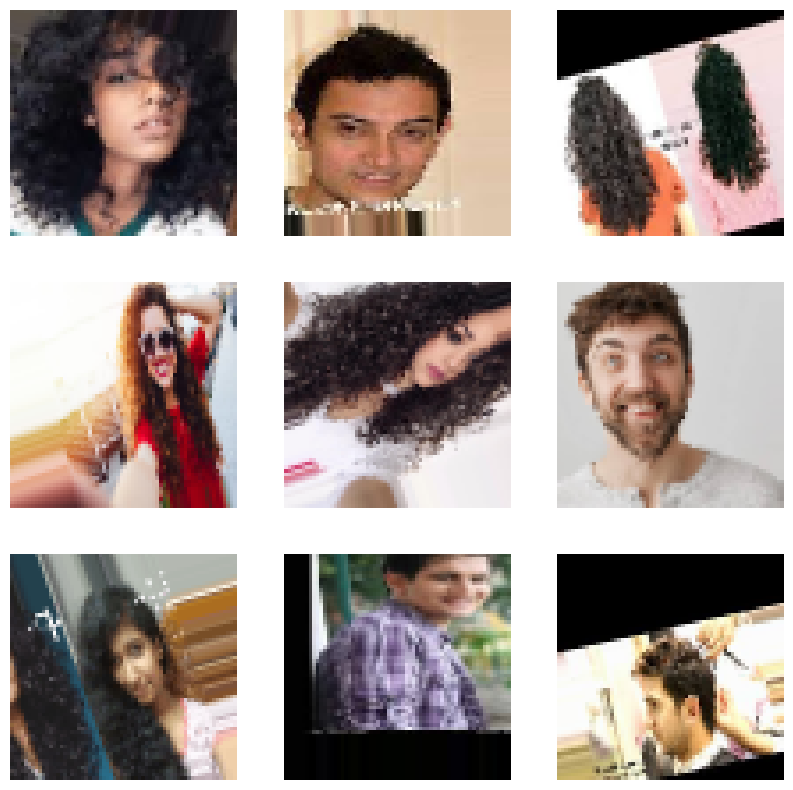

In [4]:
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images, _ = next(train_ds)

# Display the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].astype("uint8"))
    plt.axis("off")

plt.show()

In [5]:
class_names = train_ds.class_names

# Count the number of samples per class in the training set
for class_name in class_names:
    num_samples = len([filename for filename in train_ds.file_paths if class_name in filename])
    print(f"Number of {class_name} samples in the training set: {num_samples}")

# Count the number of samples per class in the validation set
for class_name in class_names:
    num_samples = len([filename for filename in val_ds.file_paths if class_name in filename])
    print(f"Number of {class_name} samples in the validation set: {num_samples}")

AttributeError: 'DirectoryIterator' object has no attribute 'class_names'

# Mixed Precision Training and Data Prefetching

1ADDED: Mixed Precision Training -  speed up training without sacrificing much in terms of accuracy

In [43]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

1ADDED: Use the prefetch transformation to overlap the preprocessing and model execution of training.

In [44]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Visualization of Training Data

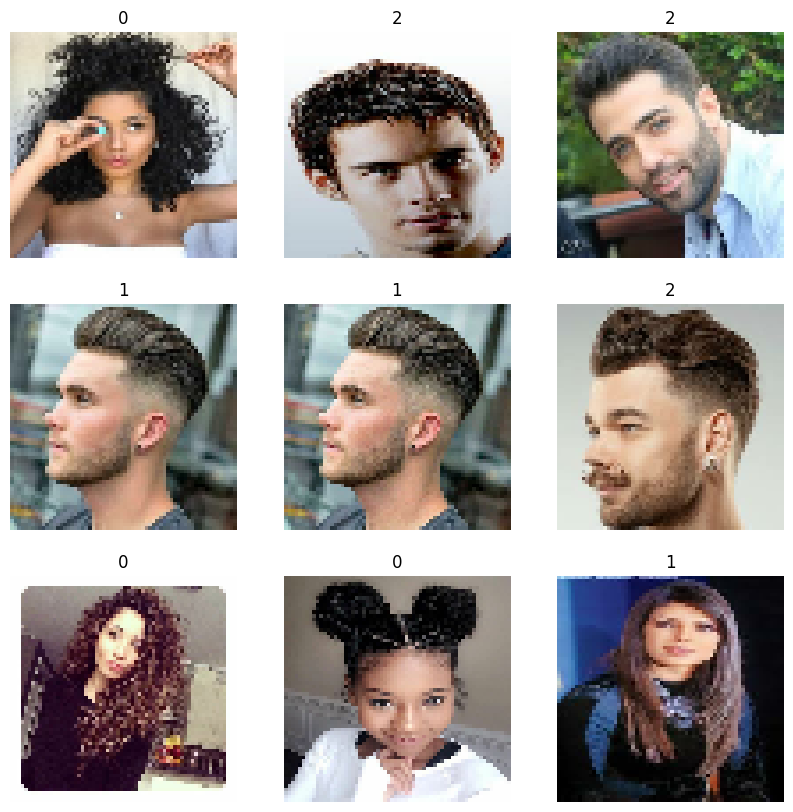

In [45]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

# Model Architecture

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(keras.Input(shape=image_size + (3,))) # 64, 64, 3
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(filters=4, kernel_size=16, strides=1, padding='valid', dilation_rate=2))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(filters=8, kernel_size=8, strides=1, padding='valid', dilation_rate=2))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(filters=16, kernel_size=4, strides=1, padding='valid', dilation_rate=2))
model.add(layers.Activation("relu"))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64))
model.add(layers.Activation("relu"))
model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))

# Visualizing Model Architecture

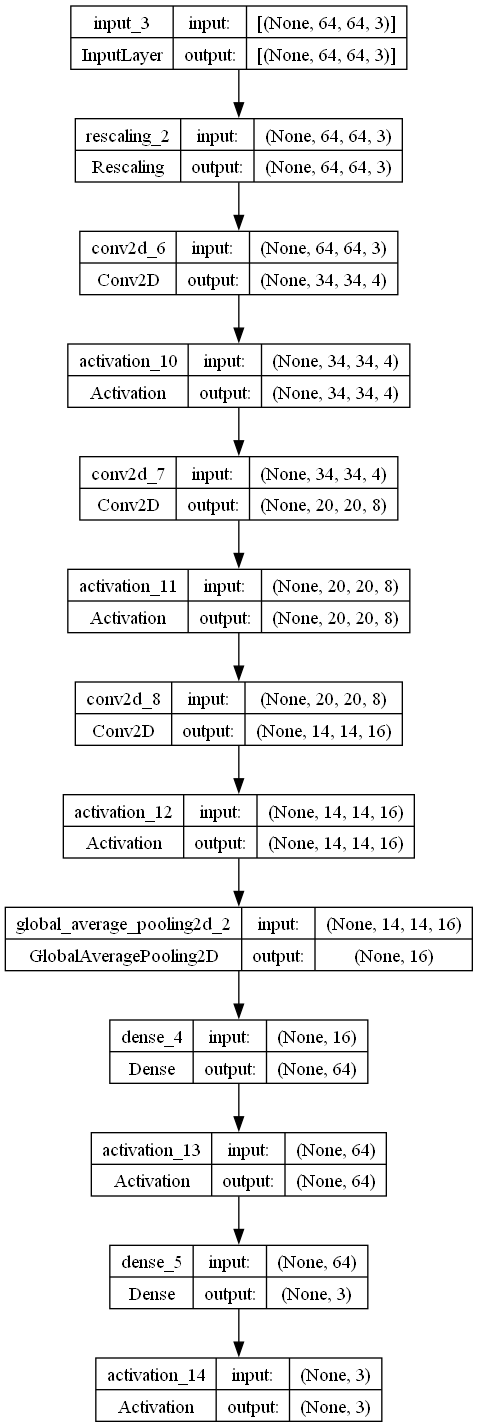

In [47]:
tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

# Display Model Summary

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 4)         3076      
                                                                 
 activation_10 (Activation)  (None, 34, 34, 4)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 8)         2056      
                                                                 
 activation_11 (Activation)  (None, 20, 20, 8)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 16)        2064      
                                                                 
 activation_12 (Activation)  (None, 14, 14, 16)       

# Model Training

In [51]:
epochs = 50

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()],
)

# Training the Model

In [52]:
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/50


25/25 [==============================] - 59s 2s/step - loss: 1.0310 - accuracy: 0.4548 - precision_3: 0.5915 - recall_3: 0.1070 - auc_3: 0.6590 - val_loss: 1.0893 - val_accuracy: 0.3827 - val_precision_3: 0.4375 - val_recall_3: 0.1071 - val_auc_3: 0.5930
Epoch 2/50
 4/25 [===>..........................] - ETA: 51s - loss: 0.9800 - accuracy: 0.5156 - precision_3: 0.6591 - recall_3: 0.2266 - auc_3: 0.7091

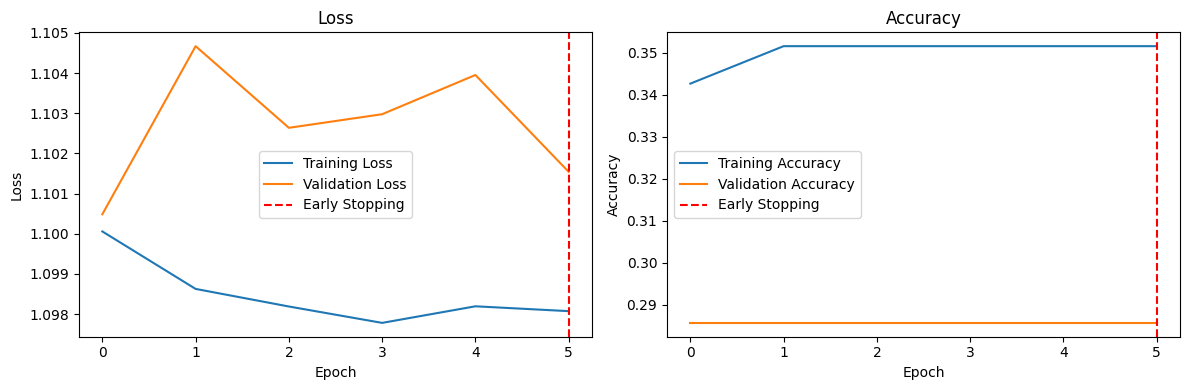

In [ ]:
import matplotlib.pyplot as plt

# Plot training history for loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(x=early_stopping.stopped_epoch, color='r', linestyle='--', label='Early Stopping')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training history for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=early_stopping.stopped_epoch, color='r', linestyle='--', label='Early Stopping')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Model Testing and Evaluation

In [ ]:
# Load and test an image of curly hair
img_curly = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array_curly = keras.preprocessing.image.img_to_array(img_curly)
img_array_curly = tf.expand_dims(img_array_curly, 0)  # Create batch axis

predictions_curly = model.predict(img_array_curly)
print(
    "CURLY: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions_curly[0])
)

# Load and test an image of straight hair
img_straight = keras.preprocessing.image.load_img(
    "hair_types/Straight_Hair/1-short-spiky-mens-haircut.jpg", target_size=image_size
)
img_array_straight = keras.preprocessing.image.img_to_array(img_straight)
img_array_straight = tf.expand_dims(img_array_straight, 0)  # Create batch axis

predictions_straight = model.predict(img_array_straight)
print(
    "STRAIGHT: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions_straight[0])
)

# Load and test an image of wavy hair
img_wavy = keras.preprocessing.image.load_img(
    "hair_types/Wavy_Hair/2-Short-High-Volume-Hairstyle.jpg", target_size=image_size
)
img_array_wavy = keras.preprocessing.image.img_to_array(img_wavy)
img_array_wavy = tf.expand_dims(img_array_wavy, 0)  # Create batch axis

predictions_wavy = model.predict(img_array_wavy)
print(
    "WAVY: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions_wavy[0])
)

1/1 [==============================] - 0s 437ms/step
CURLY: This image is 0.34 percent curly hair, 0.33 percent straight hair, and 0.33 percent wavy hair.
1/1 [==============================] - 0s 49ms/step
STRAIGHT: This image is 0.34 percent curly hair, 0.33 percent straight hair, and 0.33 percent wavy hair.
1/1 [==============================] - 0s 55ms/step
WAVY: This image is 0.34 percent curly hair, 0.33 percent straight hair, and 0.33 percent wavy hair.
